In [2]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colors import LightSource
from sklearn.cluster import KMeans
import skimage
from joblib import Parallel, delayed
#from sklearn.preprocessing import MaxAbsScaler, StandardScaler
#import sklearn.metrics as metric

In [3]:
df = pd.read_pickle("blind_cameras_dataset\\drdf_arrays.pkl")
df2arr = df.pixels.to_numpy()
arr3d = np.stack(df2arr)
data = arr3d.reshape(df2arr.shape[0],32*32)

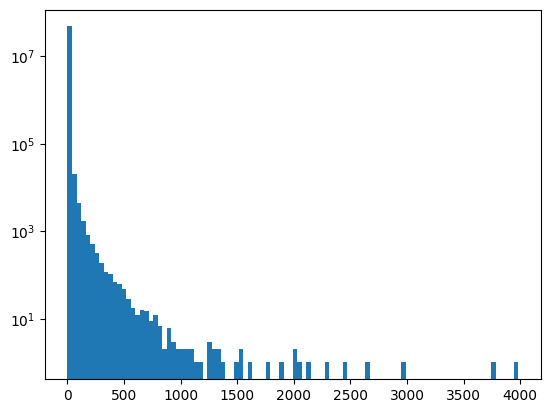

In [3]:
plt.hist(data.reshape(-1,1),100)
plt.yscale('log')

mean threshold : 11.584999 11.584999
maximum : 43.8172
ratio max/mean : 3.7822359


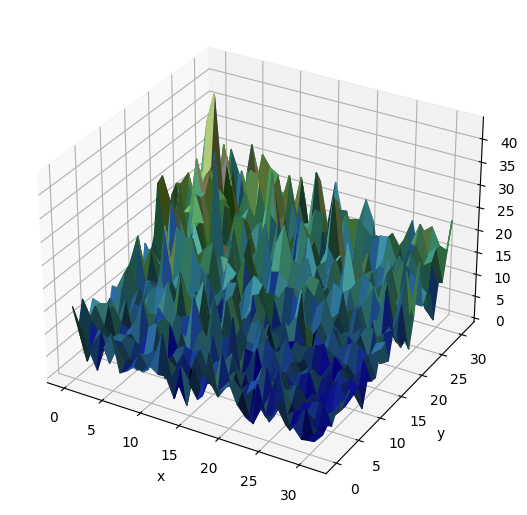

In [19]:
data_num = 21449

fig = plt.figure()
ax = plt.axes(projection='3d')

a = np.arange(32)
x,y = np.meshgrid(a,a)
z = arr3d[data_num]

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')

ax.plot_surface(x,y,z,facecolors=rgb) #cmap='viridis'
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.set_figheight(10)

print('mean threshold :',skimage.filters.threshold_mean(z))
print('maximum :', np.max(z))
print('ratio max/mean :', np.max(z)/skimage.filters.threshold_mean(z))

iso thr : 85.427826
mean thr : 45.727554
min thr : 329.51447


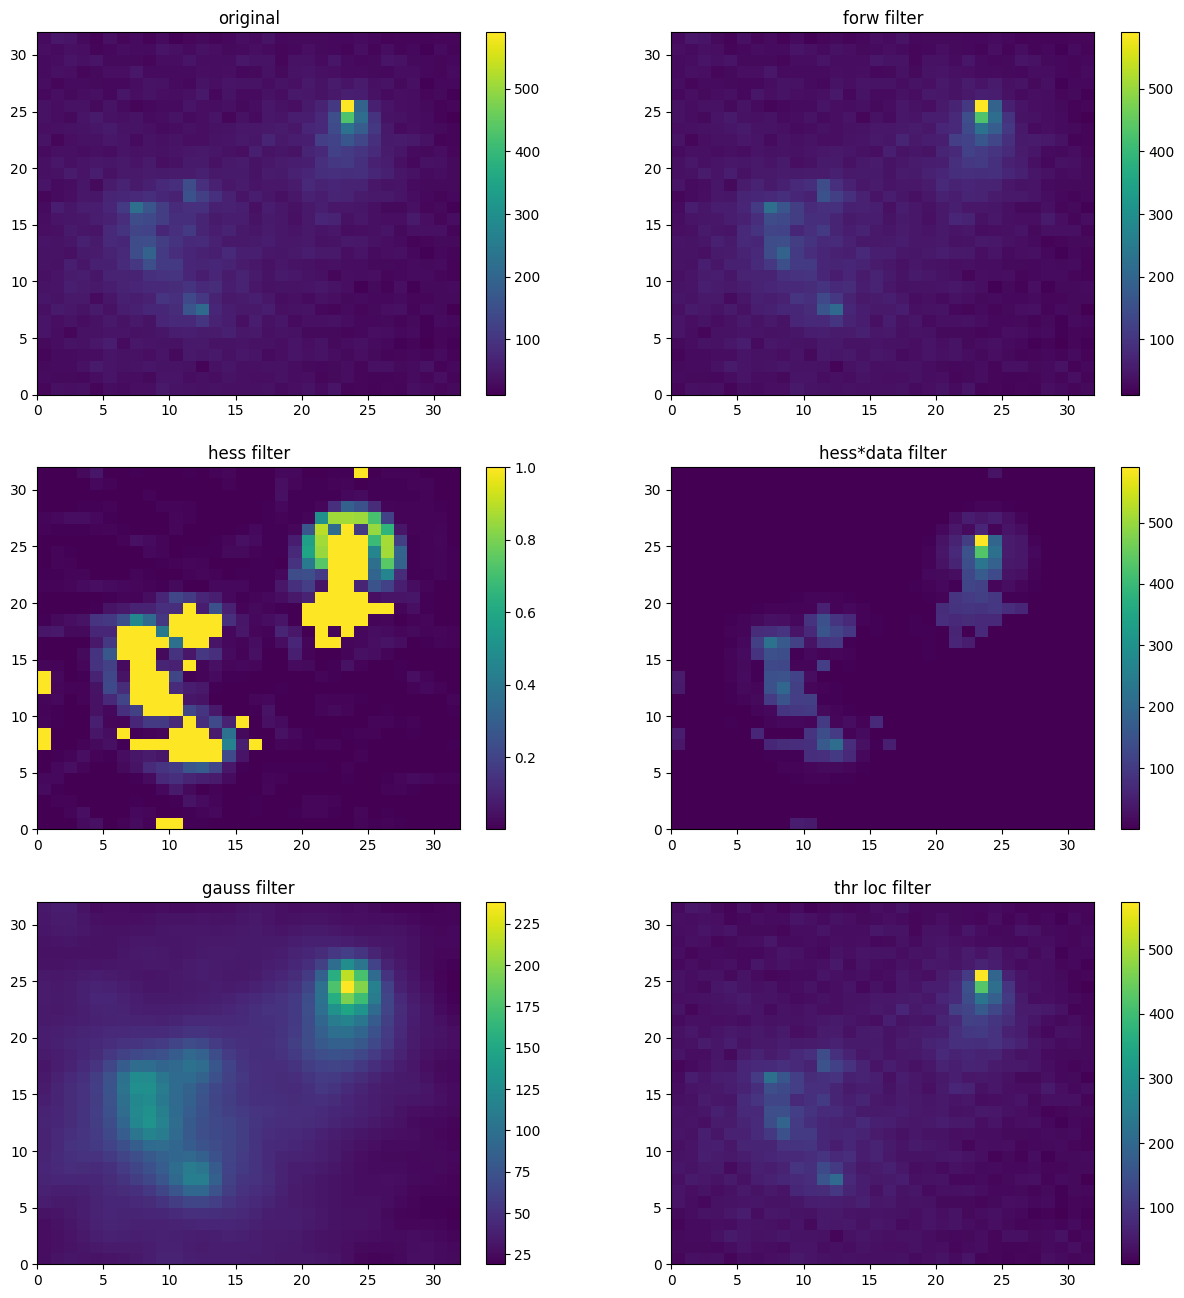

In [36]:
data_num = 42015#31#8576#39051#42015

def filt_func(r, c, sigma=0.01):
    return np.exp(-(r**2 + c**2)/(2 * sigma**2))


forw = skimage.filters.filter_forward(arr3d[data_num], filt_func)
med = skimage.filters.median(arr3d[data_num])
gauss = skimage.filters.gaussian(arr3d[data_num]) #sigma? mode?
hess = skimage.filters.hessian(arr3d[data_num]) #sigmas? scale_range?
frangi = skimage.filters.frangi(arr3d[data_num])
sato = skimage.filters.sato(arr3d[data_num])
mei = skimage.filters.meijering(arr3d[data_num])

thr_iso = skimage.filters.threshold_isodata(image=arr3d[data_num], nbins=32*32)
thr_loc = skimage.filters.threshold_local(arr3d[data_num]) #method='gaussian'
thr_mean = skimage.filters.threshold_mean(arr3d[data_num])
thr_min = skimage.filters.threshold_minimum(image=arr3d[data_num], nbins=32*32)

print('iso thr :',thr_iso)
print('mean thr :',thr_mean)
print('min thr :', thr_min)

fig, ax = plt.subplots(3,2)
cam0 = ax[0,0].pcolormesh(arr3d[data_num])
plt.colorbar(cam0)
ax[0,0].set_title('original')

cam1 = ax[0,1].pcolormesh(forw)#(arr3d[data_num]>thr_iso)
plt.colorbar(cam1)
ax[0,1].set_title('forw filter')

cam2 = ax[1,0].pcolormesh(hess)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[1,0].set_title('hess filter')

cam3 = ax[1,1].pcolormesh(hess*arr3d[data_num])#(arr3d[data_num]>thr_min)
plt.colorbar(cam3)
ax[1,1].set_title('hess*data filter')

cam2 = ax[2,0].pcolormesh(gauss)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[2,0].set_title('gauss filter')

cam2 = ax[2,1].pcolormesh(thr_loc)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[2,1].set_title('thr loc filter')

fig.set_figwidth(15)
fig.set_figheight(16)

In [ ]:
data_num = 42015

fig, ax = plt.subplots(1,2)
cam0 = ax[0].pcolormesh(arr3d[data_num])
plt.colorbar(cam0)
ax[0].set_title('non scaled')

cam = ax[1].pcolormesh(scaled2.reshape(-1,32,32)[data_num])
plt.colorbar(cam)
ax[1].set_title('scaled')

fig.set_figwidth(15)